In [25]:
# !pip install -r requirements.txt

In [4]:
import datetime

import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yfin
import matplotlib.pyplot as plt
from scipy import stats
#yfin.pdr_override() #we need this to get data from Yahoo!Finance
#from pandas_datareader.famafrench import get_available_datasets

In [6]:
# SECURITIES
# scenario 1: loan for a credit card (unsecured)
# scenario 2: loan for a house in California (collateral is the house)
# scenario 3: loan to a construction company (collateral is the building under construction, but not the land)
# scenario 4: snp500 index
# scenario 5: treasury bond (e.g. 30y)
# scenario 6: illiquid corporate bond of high quality company (choose a company)

In [7]:
# DATASETS
# scenario 1: delinquency rates on credit cards https://fred.stlouisfed.org/series/DRCCLACBS
# scenario 2: average 30y mortgage rate https://fred.stlouisfed.org/series/MORTGAGE30US 
# and mortgage delinquency rate https://fred.stlouisfed.org/series/DRSFRMACBS
# and house price index for California https://fred.stlouisfed.org/series/CASTHPI
# scenario 3: building material prices https://fred.stlouisfed.org/series/PCU44414441
# scenario 4: publicly traded equity: snp500 (fred)
# scenario 5: treasury bond 30y yield (get from Yahoo?)
# scenario 6: https://fred.stlouisfed.org/series/DAAA <- proxy for high quality illiquid bond (fred)

In [8]:
# IDEA
# WE NEED TO BUY A TREASURY BOND TO LEND IN SCENARIO 5. IT WILL BE RETURNED TO US LATER. IN THE MEANTIME ITS PRICE MOVED.
# IF ITS PRICE WENT DOWN (YIELD GOES UP), WE WILL LOSE MONEY. ON THE OTHER HAND, IF YIELD GOES UP, INTEREST RATES GO UP,
# AND SO LIKELY DELINQUENCY RATES ON CREDIT CARDS WILL GO UP (WE NEED TO PROVE THIS WITH A SCATTER PLOT AND CORRELATION VALUE).
# BUT THIS ALSO MEANS WE WILL HAVE HIGHER CREDIT RISK IN SCENARIO 1. AT THE SAME TIME, AS RATES RISE, MORTGAGE DELINQUENCY RATES
# MIGHT GO UP AND HOUSE PRICES DROP, WHICH MAKES THE COLLATERAL IN SCENARIO 2 GO DOWN AND CREDIT RISK GO UP. SO THE PROBLEMS ARE SNOWBALLING.
# IN SCENARIO 6 WE ARE LESS WORRIED BECAUSE DUE TO THE ILLIQUID NATURE OF THE BOND, WE WILL LIKELY CHOOSE NOT LIQUIDATE IT AND TO WAIT
# UNTIL ITS MATURITY AND COLLECT THE COUPONS. IN SCENARIO 4, SNP500 INDEX MIGHT GO DOWN WITH INTEREST RATES (TO BE CHECKED), AND IT
# WOULD BE INTERESTING TO ANALYSE ITS DISTRIBUTION OF RETURNS WITH A HISTORGRAM AND HOW FAR IT IS FROM A NORMAL DISTRIBUTION (CALCULATE SKEW AND KURT).
# I'M NOT SURE ABOUT SCENARIO 3, BUT I WAS THINKING THAT BUILDING MATERIALS GOING UP IN PRICE IS BAD AS IT IS LESS LIKELY THE
# CONSTRUCTION COMPANY WILL SUCCESSFULLY FINISH THE BUILDING.


In [9]:
# Renaming the data for easier interpretation
column_name_mapping = {
    'DRCCLACBS': 'CreditCardDelinq', 
    'MORTGAGE30US': 'AvgMortgageRate',
    'DRSFRMACBS': 'MortgageDelinq',
    'CASTHPI': 'HousePxIdx_CA',
    'PCU44414441': 'BuildingMaterialPx',
    'sp500': 'SP500',
    'DAAA': 'InvestmentBondYield'
}

In [31]:
# Let's hard code the end date for stable interpretation
end = datetime.date(2024, 9, 1) #datetime.date.today() 
start = end - datetime.timedelta(365 * 10)
df = web.DataReader(['DRCCLACBS', 'MORTGAGE30US', 'PCU44414441', 'sp500', 'DAAA'], 'fred', start, end) #'DRSFRMACBS', 'CASTHPI',
df.rename(columns=column_name_mapping, inplace=True)
df.head()

,CreditCardDelinq,AvgMortgageRate,BuildingMaterialPx,SP500,InvestmentBondYield
DATE,,,,,
2014-09-04,NaN,4.1,NaN,1997.65,4.03
2014-09-05,NaN,NaN,NaN,2007.71,4.10
2014-09-08,NaN,NaN,NaN,2001.54,4.08
2014-09-09,NaN,NaN,NaN,1988.44,4.09
2014-09-10,NaN,NaN,NaN,1995.69,4.13


In [32]:
# Import additional library
import yfinance as yf

# Fetch 30-year Treasury bond yield data
treasury_bond_data = yf.download('^TYX', start=start, end=end)

# Extract the relevant column
treasury_bond_yield = treasury_bond_data['Adj Close']

# Add the new column to the DataFrame
df['TreasuryBondYield'] = treasury_bond_yield

# Display the updated DataFrame
df.head()

[*********************100%%**********************]  1 of 1 completed


,CreditCardDelinq,AvgMortgageRate,BuildingMaterialPx,SP500,InvestmentBondYield,TreasuryBondYield
DATE,,,,,,
2014-09-04,NaN,4.1,NaN,1997.65,4.03,3.205
2014-09-05,NaN,NaN,NaN,2007.71,4.10,3.237
2014-09-08,NaN,NaN,NaN,2001.54,4.08,3.223
2014-09-09,NaN,NaN,NaN,1988.44,4.09,3.233
2014-09-10,NaN,NaN,NaN,1995.69,4.13,3.269


We plot all the time series of each for general qualitative analysis

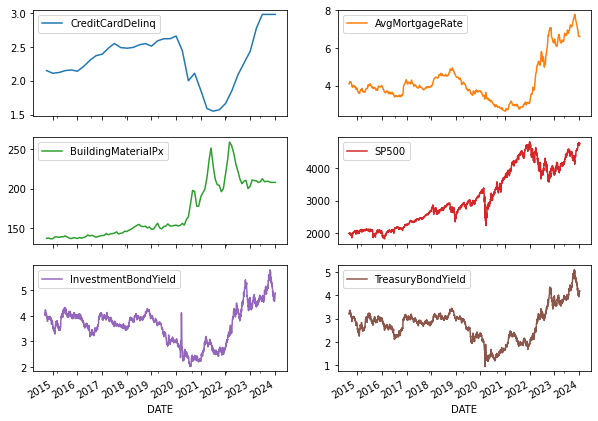

In [33]:
#interpolate on the dates just for plotting
df_interpolated = df.interpolate('index')
df_interpolated.plot(subplots=True, layout=(4,2), figsize=(10,10));

In [47]:
# The below columns have date indices on the first of the month, which may not be a business day.
# We bump their index to the next business day to better align their valid dates to those of other series (e.g. sp500).
for feature in ['BuildingMaterialPx',  'CreditCardDelinq']: #'HousePxIdx_CA', 'MortgageDelinq',
    clean_series = df[feature].dropna()
    df[feature] = pd.Series(clean_series.values, index=[d + BDay(0) for d in clean_series.index])

In [48]:
df.head()

,CreditCardDelinq,AvgMortgageRate,BuildingMaterialPx,SP500,InvestmentBondYield,TreasuryBondYield
DATE,,,,,,
2014-09-04,NaN,4.1,NaN,1997.65,4.03,3.205
2014-09-05,NaN,NaN,NaN,2007.71,4.10,3.237
2014-09-08,NaN,NaN,NaN,2001.54,4.08,3.223
2014-09-09,NaN,NaN,NaN,1988.44,4.09,3.233
2014-09-10,NaN,NaN,NaN,1995.69,4.13,3.269


In [49]:
df_returns = pd.DataFrame(index=df.index)
for c in df.columns:
    col_series = df[c].dropna()
    df_returns[c] = np.log(col_series)-np.log(col_series.shift(1))
df_returns = df_returns.iloc[1:]
df_returns.describe()

,CreditCardDelinq,AvgMortgageRate,BuildingMaterialPx,SP500,InvestmentBondYield,TreasuryBondYield
count,35.000000,487.000000,109.000000,2352.000000,2335.000000,2350.000000
mean,0.009327,0.000984,0.003854,0.000369,0.000083,0.000114
std,0.068898,0.021306,0.033099,0.011471,0.015839,0.022511
min,-0.202941,-0.072759,-0.101183,-0.127652,-0.143288,-0.259816
25%,-0.006663,-0.010472,-0.008553,-0.003897,-0.008336,-0.010715
50%,0.012821,0.000000,0.002809,0.000576,0.000000,-0.000329
75%,0.038441,0.011089,0.013555,0.005731,0.008202,0.011154
max,0.130956,0.099992,0.097311,0.089683,0.165985,0.263103


In [52]:
print(df_returns.skew())


CreditCardDelinq      -1.170533
AvgMortgageRate        0.712175
BuildingMaterialPx     0.347389
SP500                 -0.794307
InvestmentBondYield    0.609571
TreasuryBondYield     -0.391576
dtype: float64


In [53]:
print(df_returns.kurt())

CreditCardDelinq        2.534875
AvgMortgageRate         3.068681
BuildingMaterialPx      2.713219
SP500                  15.594688
InvestmentBondYield    12.685012
TreasuryBondYield      27.806092
dtype: float64


Plot a heatmap of the correlation matrix of log-returns.
The correlations against the mortgage rate, credit card delinquencies and mortgage delinquencies are not reliable as their data is quarterly and so we only have 37 datapoints to estimate correlation from, which is not enought for noisy data.
Some small yet positive correlation between bond yields and sp500 returns is present. We also observe considerable negative correlation between bond yields and house prices in CA, which is expected as an increase in interest rates tends to slow down the demand for housing.
Building material prices are somewhat positivelly correlated to sp500 returns an house prices, which may be explained by inflation.

                     BuildingMaterialPx  SP500  InvestmentBondYield
BuildingMaterialPx                1.000  0.076               -0.003
SP500                             0.076  1.000                0.036
InvestmentBondYield              -0.003  0.036                1.000


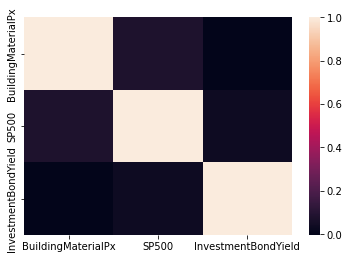

In [54]:
corr_matrix = df_returns[[ 'BuildingMaterialPx', 'SP500', 'InvestmentBondYield']].corr().round(3) #'HousePxIdx_CA',
print(corr_matrix)
sns.heatmap(corr_matrix);

In [ ]:
# chart = sns.regplot(x="SP500", y="NASDAQ", data=df).set(
#     title="Figure 3: Daily S&P 500 Returns vs NASDAQ Returns"
# )

# plt.axvline(0, 0, 1, dash_capstyle="butt", linestyle="--", color="grey")
# plt.plot([min(df.SP500), max(df.SP500)], [0, 0], linestyle="--", color="grey");

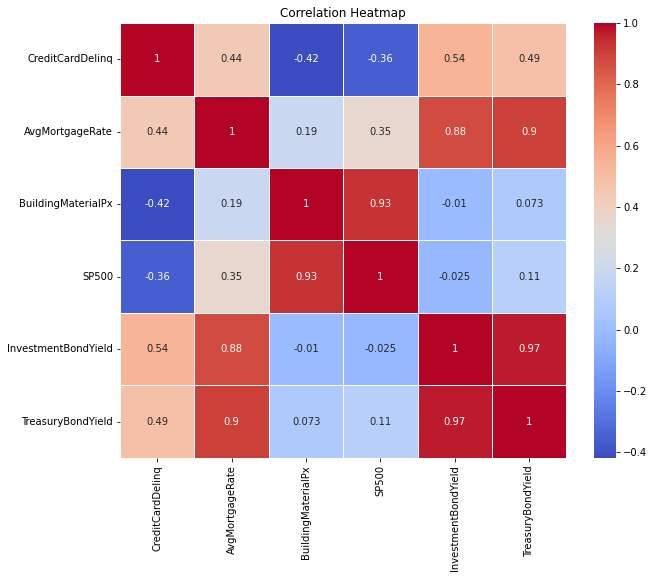

In [42]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

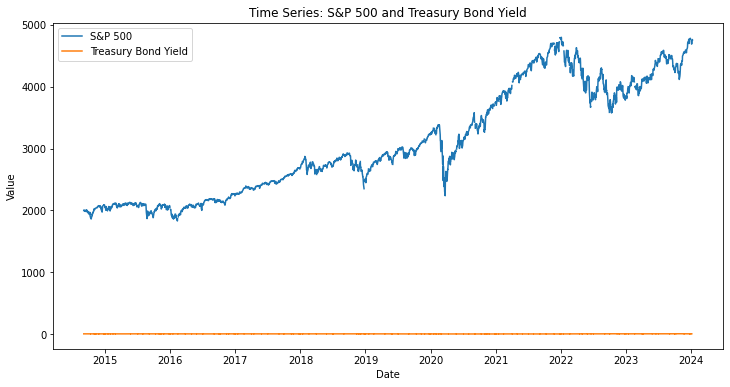

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(df['SP500'], label='S&P 500')
plt.plot(df['InvestmentBondYield'], label='Treasury Bond Yield')
plt.title('Time Series: S&P 500 and Treasury Bond Yield')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

/var/folders/dl/6vdsfqk90pg_t9t9nzvffwlc0000gn/T/ipykernel_21833/1883492053.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  snp_returns = df['SP500'].pct_change().dropna()


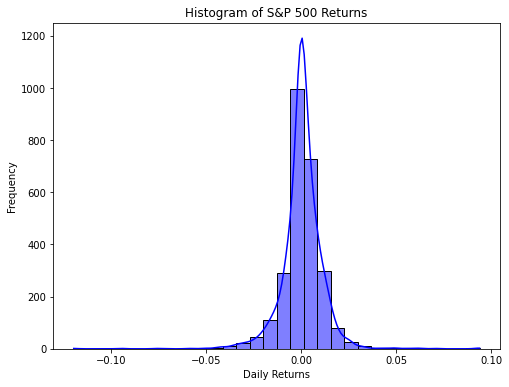

In [19]:
snp_returns = df['SP500'].pct_change().dropna()
plt.figure(figsize=(8, 6))
sns.histplot(snp_returns, bins=30, kde=True, color='blue')
plt.title('Histogram of S&P 500 Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

In [20]:
df

,CreditCardDelinq,AvgMortgageRate,MortgageDelinq,HousePxIdx_CA,BuildingMaterialPx,SP500,InvestmentBondYield
DATE,,,,,,,
2014-01-13,NaN,NaN,NaN,NaN,NaN,1819.20,4.47
2014-01-14,NaN,NaN,NaN,NaN,NaN,1838.88,4.50
2014-01-15,NaN,NaN,NaN,NaN,NaN,1848.38,4.50
2014-01-16,NaN,4.41,NaN,NaN,NaN,1845.89,4.48
2014-01-17,NaN,NaN,NaN,NaN,NaN,1838.70,4.47
...,...,...,...,...,...,...,...
2024-01-03,NaN,NaN,NaN,NaN,NaN,4704.81,4.75
2024-01-04,NaN,6.62,NaN,NaN,NaN,4688.68,4.85
2024-01-05,NaN,NaN,NaN,NaN,NaN,4697.24,4.89


In [21]:
# Import additional library
import yfinance as yf

# Fetch 30-year Treasury bond yield data
treasury_bond_data = yf.download('^TYX', start=start, end=end)

# Extract the relevant column
treasury_bond_yield = treasury_bond_data['Adj Close']

# Add the new column to the DataFrame
df['TreasuryBondYield'] = treasury_bond_yield

# Display the updated DataFrame
df.head()

[*********************100%%**********************]  1 of 1 completed


,CreditCardDelinq,AvgMortgageRate,MortgageDelinq,HousePxIdx_CA,BuildingMaterialPx,SP500,InvestmentBondYield,TreasuryBondYield
DATE,,,,,,,,
2014-01-13,NaN,NaN,NaN,NaN,NaN,1819.20,4.47,3.767
2014-01-14,NaN,NaN,NaN,NaN,NaN,1838.88,4.50,3.800
2014-01-15,NaN,NaN,NaN,NaN,NaN,1848.38,4.50,3.806
2014-01-16,NaN,4.41,NaN,NaN,NaN,1845.89,4.48,3.773
2014-01-17,NaN,NaN,NaN,NaN,NaN,1838.70,4.47,3.757


In [22]:
df

,CreditCardDelinq,AvgMortgageRate,MortgageDelinq,HousePxIdx_CA,BuildingMaterialPx,SP500,InvestmentBondYield,TreasuryBondYield
DATE,,,,,,,,
2014-01-13,NaN,NaN,NaN,NaN,NaN,1819.20,4.47,3.767
2014-01-14,NaN,NaN,NaN,NaN,NaN,1838.88,4.50,3.800
2014-01-15,NaN,NaN,NaN,NaN,NaN,1848.38,4.50,3.806
2014-01-16,NaN,4.41,NaN,NaN,NaN,1845.89,4.48,3.773
2014-01-17,NaN,NaN,NaN,NaN,NaN,1838.70,4.47,3.757
...,...,...,...,...,...,...,...,...
2024-01-03,NaN,NaN,NaN,NaN,NaN,4704.81,4.75,4.056
2024-01-04,NaN,6.62,NaN,NaN,NaN,4688.68,4.85,4.137
2024-01-05,NaN,NaN,NaN,NaN,NaN,4697.24,4.89,4.200
